In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity

from movie_sentiment.processing.arcs import get_all_polynomials, get_all_reshaped_arcs, get_all_arcs, get_all_dyn_arcs

### Loading data

In [2]:
#arcs = get_all_reshaped_arcs()
arcs = get_all_reshaped_arcs(dyn_avg=True)

Loading data from pickle file


In [3]:
X = arcs.drop(columns='movie_name')

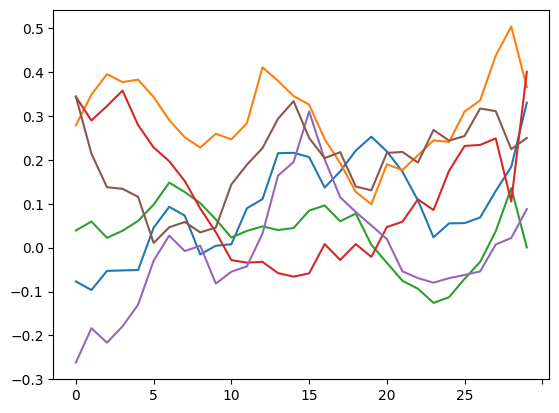

In [4]:
plots_range = range(6)

for i in plots_range:
    X.iloc[i].plot()

### Scaled data

In [5]:
s_scaler = StandardScaler()
s_scaler.fit(X.T)
scaled = s_scaler.transform(X.T)

X_scaled = pd.DataFrame(scaled.T, columns=X.columns)

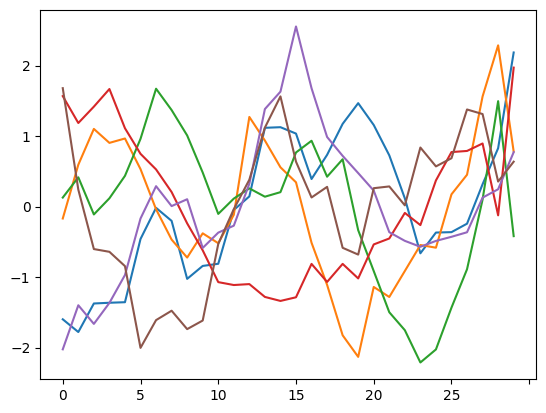

In [6]:
for i in plots_range:
    X_scaled.iloc[i].plot()

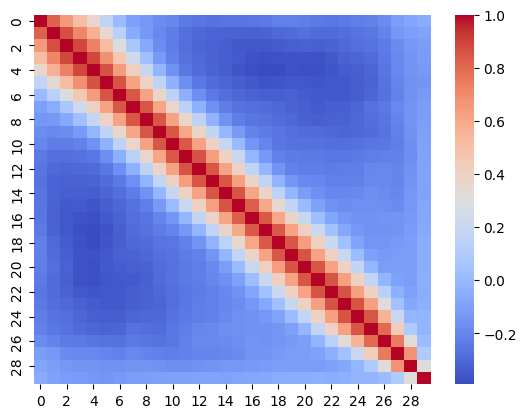

In [7]:
sns.heatmap(X_scaled.corr(), cmap='coolwarm');

### PCA

In [8]:
pca = PCA()
pca.fit(X_scaled)

PCA()

In [9]:
X_proj = pca.transform(X_scaled)
X_proj = pd.DataFrame(X_proj, columns=[f'PC{i}' for i in range(1, X_scaled.shape[1]+1)])

In [10]:
X_proj.var() / sum(X_proj.var())

PC1     2.601063e-01
PC2     1.779900e-01
PC3     1.322823e-01
PC4     1.037203e-01
PC5     8.210752e-02
PC6     6.611946e-02
PC7     4.905339e-02
PC8     3.305873e-02
PC9     2.139541e-02
PC10    1.410557e-02
PC11    9.080108e-03
PC12    6.923960e-03
PC13    5.724660e-03
PC14    5.375332e-03
PC15    4.770659e-03
PC16    4.484232e-03
PC17    3.898904e-03
PC18    3.321120e-03
PC19    2.873209e-03
PC20    2.459346e-03
PC21    1.998822e-03
PC22    1.748677e-03
PC23    1.369725e-03
PC24    1.247204e-03
PC25    1.121380e-03
PC26    9.989285e-04
PC27    9.395339e-04
PC28    8.684716e-04
PC29    8.567905e-04
PC30    1.372590e-31
dtype: float64

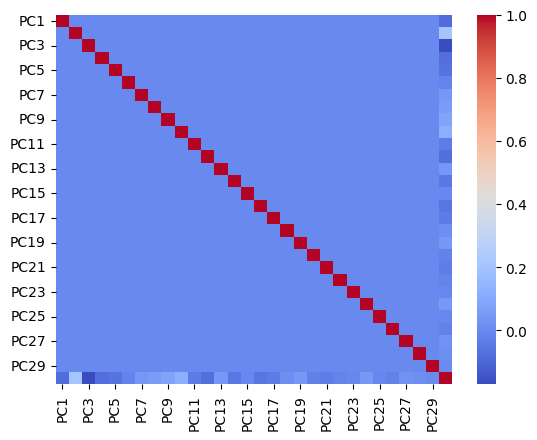

In [11]:
sns.heatmap(X_proj.corr(), cmap='coolwarm');

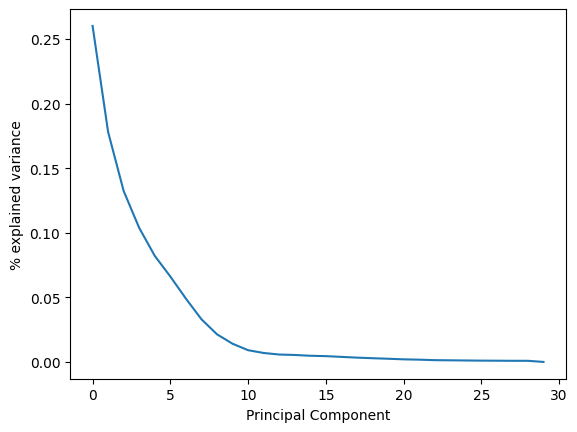

In [12]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); plt.ylabel('% explained variance');

### Kmeans

In [35]:
km = KMeans(n_clusters=6, random_state=42)
km.fit(X_proj)

/Users/sebhoch/.pyenv/versions/3.10.6/envs/movie-sentiment-analysis/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=6, random_state=42)

In [14]:
km.inertia_

47593.48974285458

<Axes: xlabel='PC1', ylabel='PC2'>

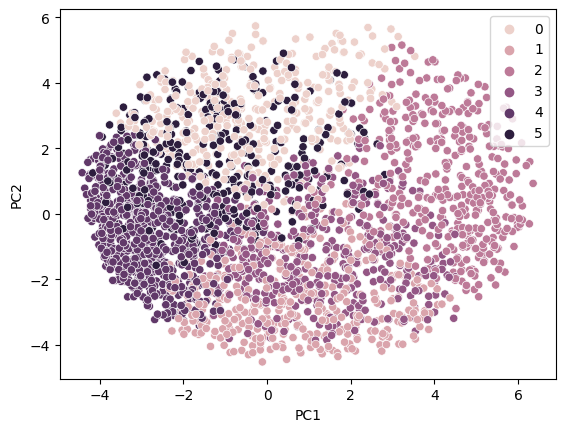

In [15]:
sns.scatterplot(x=X_proj.iloc[:,0], y=X_proj.iloc[:,1], hue=km.predict(X_proj))

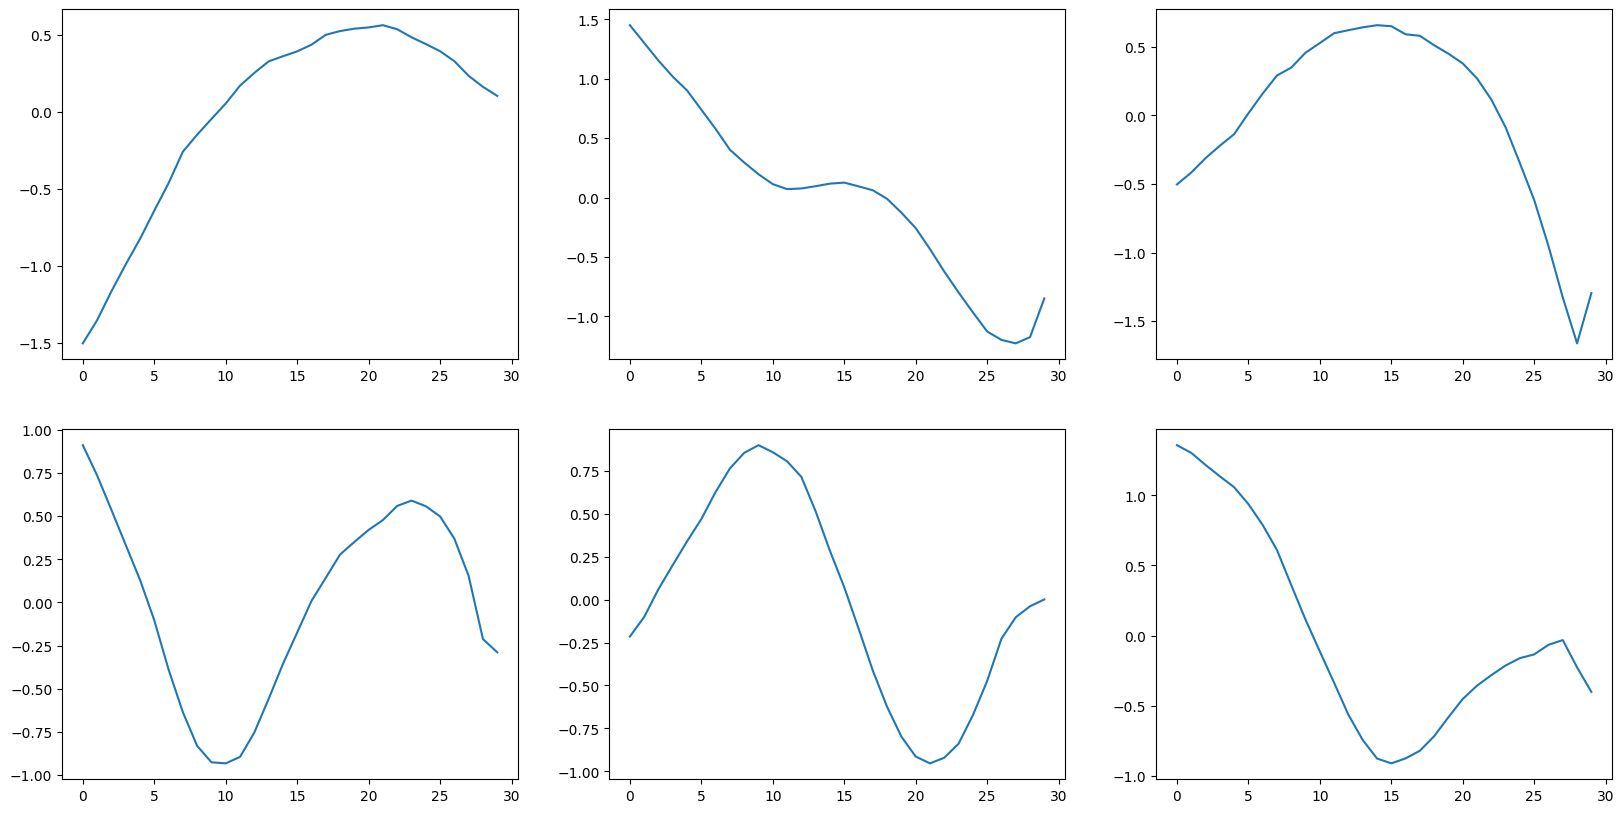

In [36]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
for i in range (6):
    row = int(i/3)
    col = i%3
    arc = pca.inverse_transform(km.cluster_centers_[i])
    ax[row,col].plot(arc)

### Plotting the results

In [37]:
np.unique(km.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5], dtype=int32), array([418, 626, 474, 375, 431, 448]))

In [38]:
classified_arcs = arcs.copy()
classified_arcs['classification'] = km.labels_

for i in range(30):
    classified_arcs[i] = X_scaled[i]

In [39]:
arc_kmeans = [] 
for i in range(6):
    arc_kmeans.append(pca.inverse_transform(km.cluster_centers_[i]))

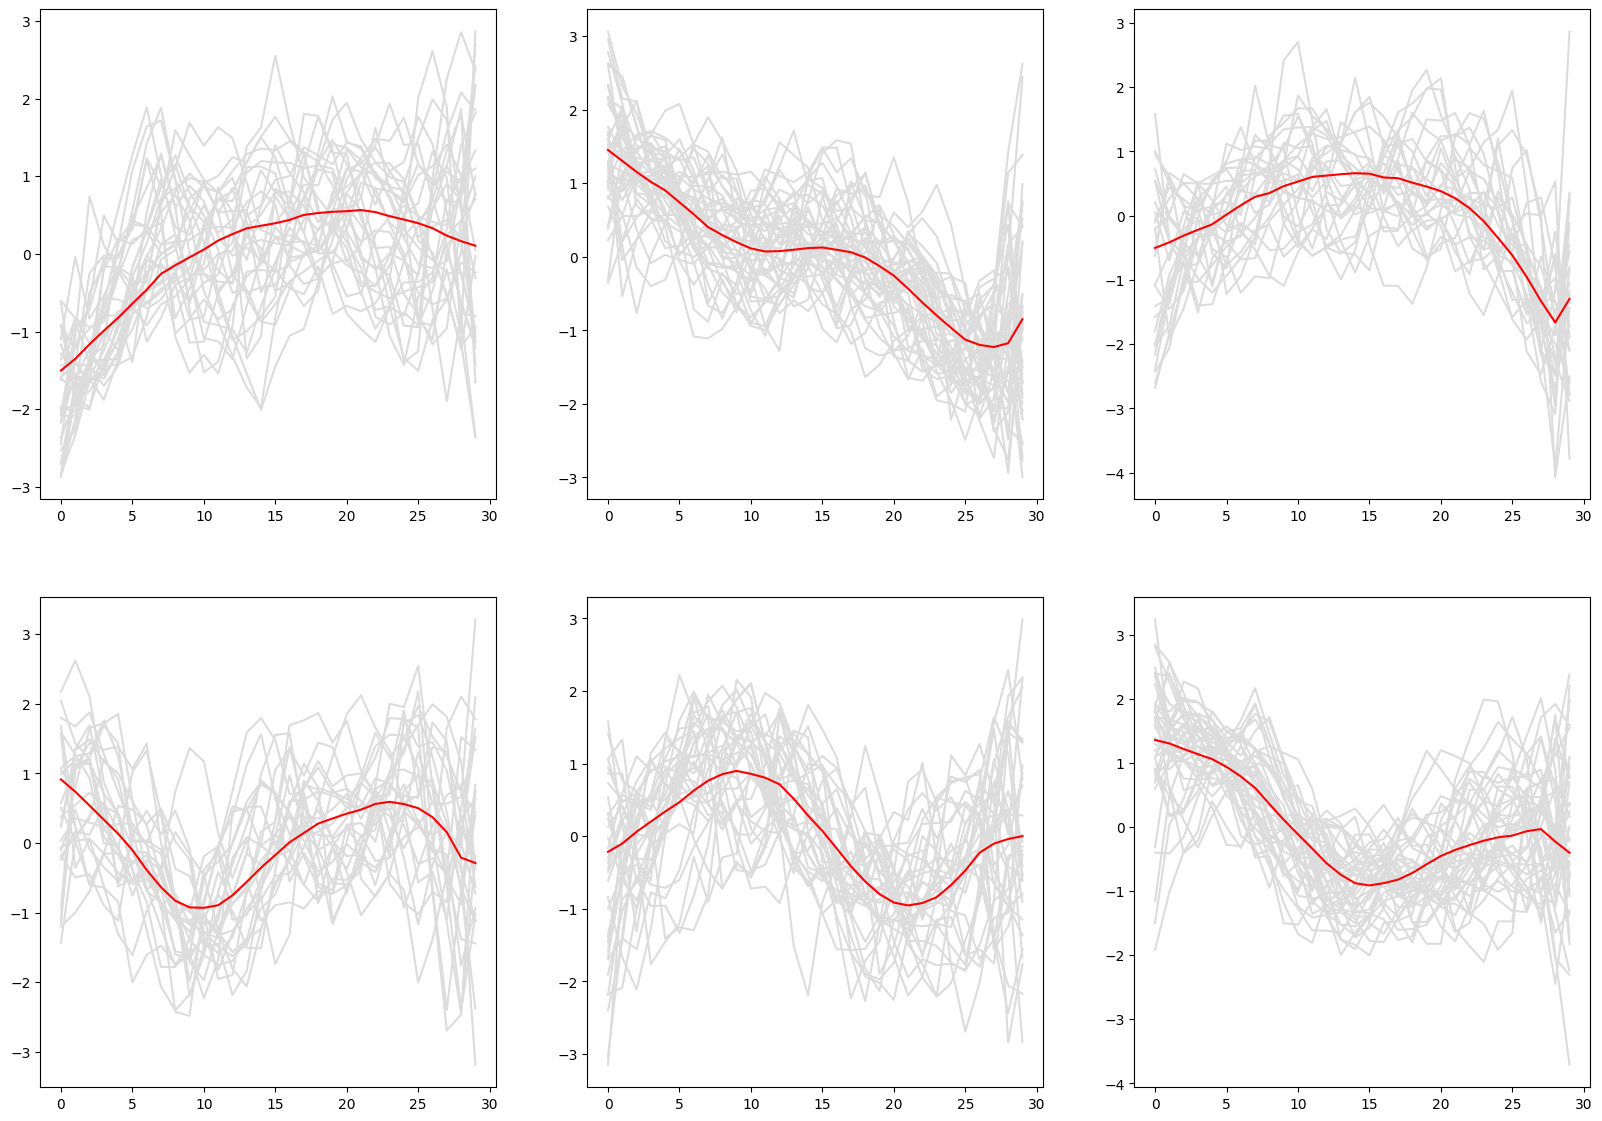

In [40]:
fig, ax = plt.subplots(2, 3, figsize=(20,14))
plot_columns = [i for i in range(30)]

for row in classified_arcs.iloc[:200,:].iterrows():
    i = row[1]['classification']
    r = int(i/3)
    c = i%3
    arc = row[1][plot_columns]
    ax[r,c].plot(arc, color='gainsboro')
    
for i in range(6):
    r = int(i/3)
    c = i%3
    ax[r,c].plot(arc_kmeans[i], color='red')

### plot some movies

In [33]:
ARCS_TYPES = {
    0: '~ Rags to riches',
    1: 'Riches to rags',
    2: 'Icarus',
    3: 'Oedipus',
    4: 'Cinderella',
    5: 'Man in a hole'
}

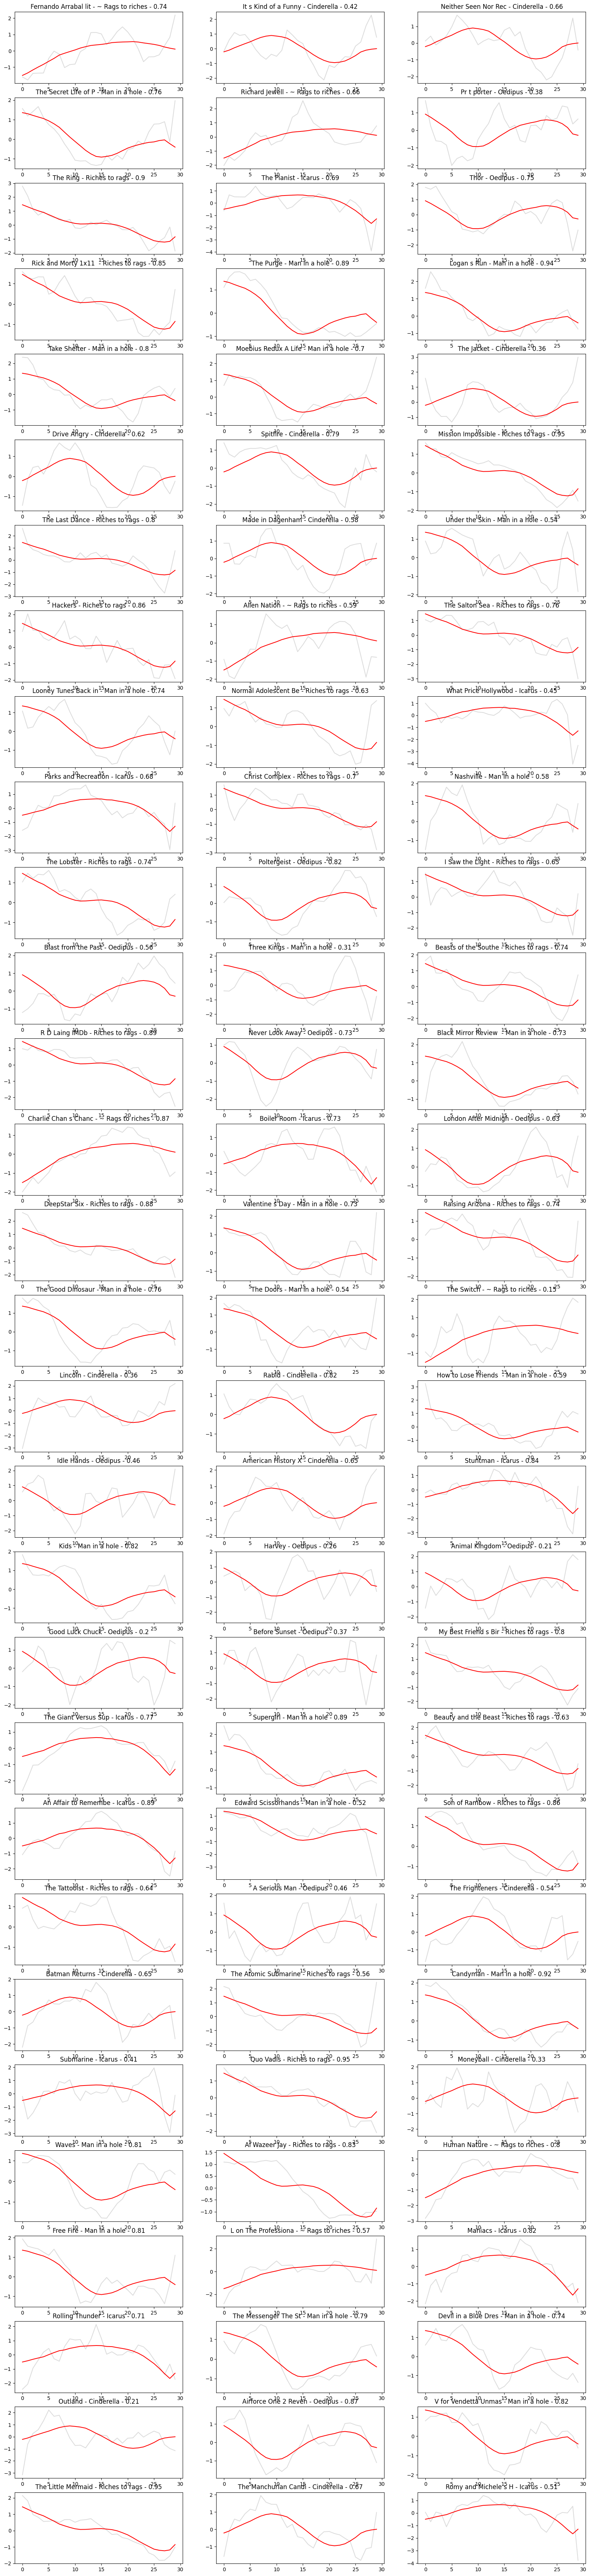

In [45]:
fig, ax = plt.subplots(30, 3, figsize=(20,90))
plot_columns = [i for i in range(30)]

for index, row in classified_arcs.iloc[:90,:].iterrows():
    r = int(index/3)
    c = index%3
    
    arc = row[plot_columns]
    #arc = X.loc[index]
    ax[r,c].plot(arc, color='gainsboro')
    
    shape = row['classification']
    ax[r,c].plot(arc_kmeans[shape], color='red')
    
    similarity = cosine_similarity(np.array(arc).reshape(1, -1), np.array(arc_kmeans[shape]).reshape(1, -1))
    similarity = round(similarity[0][0], 2)
    ax[r,c].set_title(f"{row['movie_name'][:20]} - {ARCS_TYPES[shape]} - {similarity}")

### Compute the "accuracy" scores

In [23]:
classification_scores = []

for index, row in classified_arcs.iterrows():
    arc_columns = [i for i in range(30)]
    arc = row[arc_columns]
    centroid_arc = arc_kmeans[row['classification']]

    similarity = cosine_similarity(np.array(arc).reshape(1, -1), np.array(centroid_arc).reshape(1, -1))
    similarity = round(similarity[0][0], 2)
    
    classification_scores.append(similarity)

In [24]:
classified_arcs['classification_score'] = classification_scores

In [25]:
len(classified_arcs[classified_arcs['classification_score'] < 0.5])

534

In [26]:
classification_df = classified_arcs[['movie_name', 'classification', 'classification_score']].set_index('movie_name')
classification_df

,classification,classification_score
movie_name,,
Fernando Arrabal lit Sa corolle noire ditions A Biren suivi de Ah la belle ann e ditions Ginasservis et Paris,2,0.72
It s Kind of a Funny Story,5,0.43
Neither Seen Nor Recognized,1,0.61
The Secret Life of Pets,5,0.75
Richard Jewell,2,0.59
...,...,...
Lord of Illusions,1,0.77
First Reformed,4,0.77
Then She Was Gone,1,0.78


In [27]:
movie = classification_df[classification_df.index == "Kill Bill Vol 1"]

### Test functions

In [28]:
from movie_sentiment.ml_logic.classification import get_movie_arcs_classified, get_movie_classification

In [29]:
classified_movies, arcs_kmeans = get_movie_arcs_classified()

Loading df from pickle file
Loading centroids from pickle file


In [30]:
classified_movies

,classification,classification_score
movie_name,,
Fernando Arrabal lit Sa corolle noire ditions A Biren suivi de Ah la belle ann e ditions Ginasservis et Paris,0,0.74
It s Kind of a Funny Story,4,0.42
Neither Seen Nor Recognized,4,0.66
The Secret Life of Pets,5,0.76
Richard Jewell,0,0.66
...,...,...
Lord of Illusions,2,0.75
First Reformed,5,0.81
Then She Was Gone,2,0.56


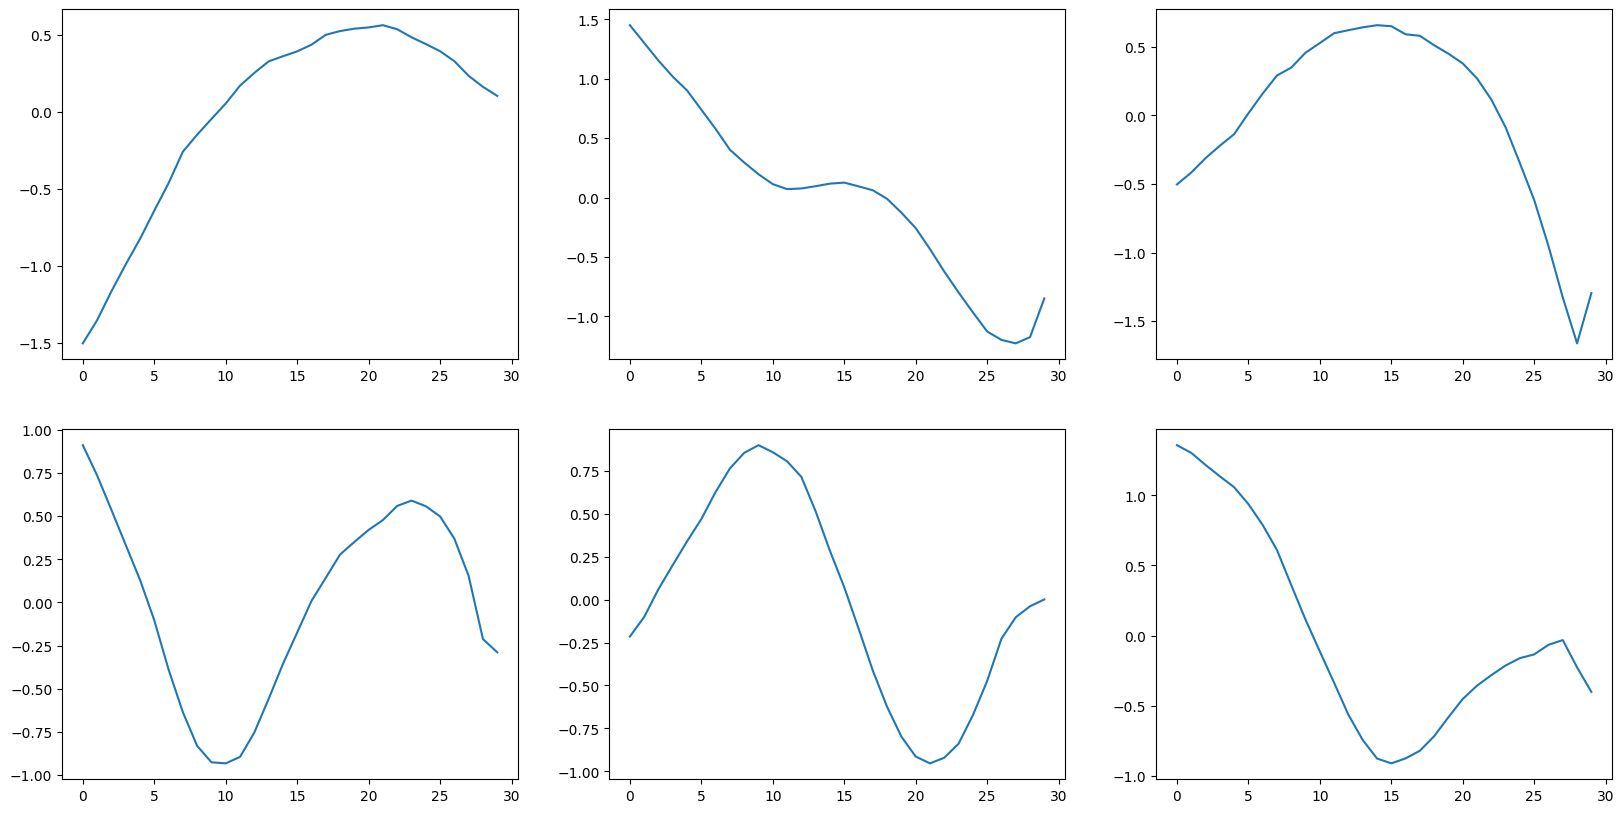

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))
for i in range (6):
    row = int(i/3)
    col = i%3
    arc = arcs_kmeans[i]
    ax[row,col].plot(arc)

In [32]:
get_movie_classification('Kill Bill Vol 1')

Loading df from pickle file
Loading centroids from pickle file


('~ Rags to riches', 0.57)